# Create RNN dataset

## Use YOLO model to predict Heldout set

In [1]:
from ultralytics import YOLO
from pathlib import Path
import json
import pandas as pd

heldout_df = pd.read_csv("data/pillbox_heldout_F_cleaned.csv")

model = YOLO('runs/detect/pill_imprint_v17/weights/best.pt')

image_dir = Path('data/pillbox_production_images_full_202008')
heldout_df['image_path'] = heldout_df['original_name'].apply(lambda x: image_dir / x if pd.notna(x) else None)
heldout_df['exists'] = heldout_df['image_path'].apply(lambda x: x.exists() if x else False)

valid_images = heldout_df[heldout_df['exists']]['image_path'].tolist()

predictions = []
batch_size = 200

print(f"Processing {len(valid_images)} images in batches of {batch_size}...")


for i in range(0, len(valid_images), batch_size):
    batch = valid_images[i:i+batch_size]
    results = model.predict(
        batch,
        conf=0.15,
        verbose=False)
    
    for img_path, result in zip(batch, results):
        detections = []
        for box in result.boxes:
            detections.append({
                'class_id': int(box.cls),
                'class_name': result.names[int(box.cls)],
                'confidence': float(box.conf),
                'bbox': box.xywhn.tolist()[0]
            })
        predictions.append({
            'image': img_path.name,
            'detections': detections
        })
    
    print(f"Processed {min(i+batch_size, len(valid_images))}/{len(valid_images)}")

with open('heldout_predictions.json', 'w') as f:
    json.dump(predictions, f, indent=2)

print(f"Saved predictions to heldout_predictions.json") 

Processing 7594 images in batches of 200...
Processed 200/7594
Processed 400/7594
Processed 600/7594
Processed 800/7594
Processed 1000/7594
Processed 1200/7594
Processed 1400/7594
Processed 1600/7594
Processed 1800/7594
Processed 2000/7594
Processed 2200/7594
Processed 2400/7594
Processed 2600/7594
Processed 2800/7594
Processed 3000/7594
Processed 3200/7594
Processed 3400/7594
Processed 3600/7594
Processed 3800/7594
Processed 4000/7594
Processed 4200/7594
Processed 4400/7594
Processed 4600/7594
Processed 4800/7594
Processed 5000/7594
Processed 5200/7594
Processed 5400/7594
Processed 5600/7594
Processed 5800/7594
Processed 6000/7594
Processed 6200/7594
Processed 6400/7594
Processed 6600/7594
Processed 6800/7594
Processed 7000/7594
Processed 7200/7594
Processed 7400/7594
Processed 7594/7594
Saved predictions to heldout_predictions.json


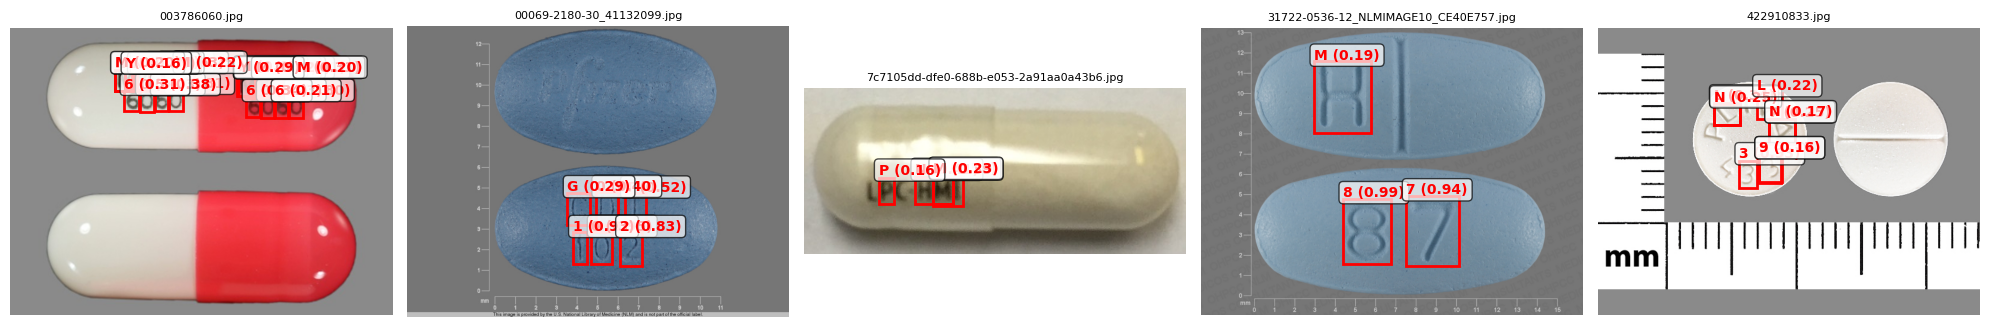

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

with open('heldout_predictions.json') as f:
    predictions = json.load(f)

samples = random.sample(predictions, 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, pred in zip(axes, samples):
    img_path = image_dir / pred['image']
    img = Image.open(img_path)
    ax.imshow(img)
    
    img_width, img_height = img.size
    
    for det in pred['detections']:
        x_center, y_center, w, h = det['bbox']
        x = (x_center - w/2) * img_width
        y = (y_center - h/2) * img_height
        
        rect = patches.Rectangle((x, y), w * img_width, h * img_height,
                                linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        ax.text(x, y - 5, f"{det['class_name']} ({det['confidence']:.2f})",
               color='red', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    ax.set_title(pred['image'], fontsize=8)

plt.tight_layout()
plt.show()

## Use ResNet model to predice on Heldout set

In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import json

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

class MultiTaskResNet(nn.Module):
    def __init__(self, num_shapes, num_colors):
        super().__init__()
        self.backbone = models.resnet18(weights=None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.shape_head = nn.Linear(in_features, num_shapes)
        self.color_head = nn.Linear(in_features, num_colors)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.shape_head(features), self.color_head(features)

checkpoint = torch.load('resnet_model/pill_classifier_full.pth', weights_only=False)
resnet_model = MultiTaskResNet(checkpoint['num_shape_classes'], checkpoint['num_color_classes']).to(device)
resnet_model.load_state_dict(checkpoint['model_state_dict'])
resnet_model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

with open('heldout_predictions.json') as f:
    yolo_preds = json.load(f)

resnet_preds = []
for i in tqdm(range(0, len(yolo_preds), 100)):
    batch = yolo_preds[i:i+100]
    imgs = torch.stack([transform(Image.open(image_dir / p['image']).convert('RGB')) for p in batch]).to(device)
    
    with torch.no_grad():
        shape_out, color_out = resnet_model(imgs)
    
    for j, pred in enumerate(batch):
        resnet_preds.append({
            'image': pred['image'],
            'shape': checkpoint['shape_encoder'].inverse_transform([shape_out[j].argmax().item()])[0],
            'color': checkpoint['color_encoder'].inverse_transform([color_out[j].argmax().item()])[0]
        })

with open('heldout_resnet_predictions.json', 'w') as f:
    json.dump(resnet_preds, f, indent=2)

print(f"Saved {len(resnet_preds)} predictions")

Python(91928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 76/76 [01:27<00:00,  1.15s/it]

Saved 7594 predictions


# Preprocess Splimprint (ground truth labels)

In [4]:
import json
from pathlib import Path
image_dir = Path('data/pillbox_production_images_full_202008')

In [5]:
import re
import pandas as pd

# Load ground truth labels
heldout_df = pd.read_csv("data/pillbox_heldout_F_cleaned.csv")

# Find all non-alphanumeric symbols in splimprint
symbols = {}
for idx, row in heldout_df.iterrows():
    imprint = str(row['splimprint'])
    if imprint != 'nan':
        non_alnum = re.findall(r'[^A-Za-z0-9]', imprint)
        for sym in set(non_alnum):
            if sym not in symbols:
                symbols[sym] = []
            if len(symbols[sym]) < 5:  # Keep max 5 examples
                symbols[sym].append(imprint)

# Display results
print("Non-alphanumeric symbols found in splimprint:")
print("=" * 60)
for sym, examples in sorted(symbols.items()):
    print(f"\nSymbol: '{sym}'")
    print(f"Examples: {examples[:5]}")

Non-alphanumeric symbols found in splimprint:

Symbol: ' '
Examples: ['WPI;2228 OR PLIVA;517', 'WPI;2229 OR PLIVA;430']

Symbol: '-'
Examples: ['54-980', 'West-ward;248', 'West-ward;939', 'Macrodantin;100;mg;0149-0009', 'APO;QU-40']

Symbol: '.'
Examples: ['Deltasone;2.5', 'ROCALTROL;0.25;ROCHE', 'ROCALTROL;0.5;ROCHE']

Symbol: '/'
Examples: ['U/121;2½', 'IL/3613']

Symbol: ';'
Examples: ['5892;V', 'par;129', 'R;2577', 'E;2;5', 'ASPIRIN;44;249']

Symbol: '½'
Examples: ['U/121;2½']


## Process symbols

In [6]:
# Clean splimprint: replace ';', '-', '/' with '_'
heldout_df['splimprint_clean'] = heldout_df['splimprint'].str.replace('[;/-]', '_', regex=True)

# Replace ' OR ' with '_'
heldout_df['splimprint_clean'] = heldout_df['splimprint_clean'].str.replace(' OR ', '_', regex=False)

# Replace ½ with 1_2
heldout_df['splimprint_clean'] = heldout_df['splimprint_clean'].str.replace('½', '1_2', regex=False)

# Show some examples of changes
changed = heldout_df[heldout_df['splimprint'] != heldout_df['splimprint_clean']][['splimprint', 'splimprint_clean']].head(10)
print("Example conversions:")
print(changed.to_string(index=False))
print(f"\nTotal changed: {(heldout_df['splimprint'] != heldout_df['splimprint_clean']).sum()}")

Example conversions:
    splimprint splimprint_clean
        5892;V           5892_V
       par;129          par_129
        R;2577           R_2577
         E;2;5            E_2_5
ASPIRIN;44;249   ASPIRIN_44_249
        AR;788           AR_788
         93;16            93_16
           NaN              NaN
         W;905            W_905
        WW;300           WW_300

Total changed: 6188


In [7]:
# Final check for remaining non-alphanumeric symbols
remaining_symbols = {}
for idx, row in heldout_df.iterrows():
    imprint = str(row['splimprint_clean'])
    if imprint != 'nan':
        non_alnum = re.findall(r'[^A-Za-z0-9_]', imprint)  # Allow underscore
        for sym in set(non_alnum):
            if sym not in remaining_symbols:
                remaining_symbols[sym] = []
            if len(remaining_symbols[sym]) < 5:
                remaining_symbols[sym].append(imprint)

if remaining_symbols:
    print("Remaining non-alphanumeric symbols (excluding '_'):")
    print("=" * 60)
    for sym, examples in sorted(remaining_symbols.items()):
        print(f"\nSymbol: '{sym}'")
        print(f"Examples: {examples[:5]}")
else:
    print("✓ No remaining symbols! All clean (only A-Z, 0-9, _)")

Remaining non-alphanumeric symbols (excluding '_'):

Symbol: '.'
Examples: ['Deltasone_2.5', 'ROCALTROL_0.25_ROCHE', 'ROCALTROL_0.5_ROCHE']


# Encode ResNet and YOLO predictions

In [8]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load YOLO predictions
with open('heldout_predictions.json', 'r') as f:
    yolo_predictions = json.load(f)

# Load ResNet predictions
with open('heldout_resnet_predictions.json', 'r') as f:
    resnet_predictions = json.load(f)

# Load ground truth labels from the cleaned heldout_df (from previous cells)
label_dict = dict(zip(heldout_df['original_name'], heldout_df['splimprint_clean']))

# Filter: keep only images with ground truth labels AND detections
yolo_filtered = []
for pred in yolo_predictions:
    img_name = pred['image']
    has_detections = len(pred.get('detections', [])) > 0
    has_label = img_name in label_dict and pd.notna(label_dict[img_name])
    
    if has_detections and has_label:
        yolo_filtered.append(pred)

print(f"Filtered: {len(yolo_predictions)} -> {len(yolo_filtered)} images")
print(f"  (removed {len(yolo_predictions) - len(yolo_filtered)} without detections or labels)")

# Dynamically find all unique values
all_chars = set()
all_shapes = set()
all_colors = set()

for pred in yolo_filtered:
    for det in pred.get('detections', []):
        all_chars.add(det['class_name'].upper())

for pred in resnet_predictions:
    all_shapes.add(pred['shape'])
    all_colors.add(pred['color'])

# Convert to sorted lists
ALL_CHARS = sorted(list(all_chars))
ALL_SHAPES = sorted(list(all_shapes))
ALL_COLORS = sorted(list(all_colors))

print(f"\nFound {len(ALL_CHARS)} unique characters: {ALL_CHARS}")
print(f"Found {len(ALL_SHAPES)} unique shapes: {ALL_SHAPES}")
print(f"Found {len(ALL_COLORS)} unique colors: {ALL_COLORS}")

# Create one-hot encoders
char_encoder = OneHotEncoder(categories=[ALL_CHARS], sparse_output=False)
char_encoder.fit(np.array(ALL_CHARS).reshape(-1, 1))

shape_encoder = OneHotEncoder(categories=[ALL_SHAPES], sparse_output=False)
shape_encoder.fit(np.array(ALL_SHAPES).reshape(-1, 1))

color_encoder = OneHotEncoder(categories=[ALL_COLORS], sparse_output=False)
color_encoder.fit(np.array(ALL_COLORS).reshape(-1, 1))

# Create lookup dict for ResNet predictions
resnet_dict = {pred['image']: pred for pred in resnet_predictions}

def sort_boxes_left_to_right(boxes):
    """Sort bounding boxes left-to-right, top-to-bottom"""
    if len(boxes) == 0:
        return []
    
    # Extract centers
    centers = [(box['bbox'][0], box['bbox'][1]) for box in boxes]
    
    # Sort by y first (rows), then x (columns within row)
    # Use smaller multiplier for y to avoid over-prioritizing vertical position
    sorted_indices = sorted(range(len(centers)), 
                           key=lambda i: (round(centers[i][1] * 10), centers[i][0]))
    
    return [boxes[i] for i in sorted_indices]

def process_single_image(yolo_pred, resnet_pred):
    """Process one image with both YOLO and ResNet predictions"""
    detections = yolo_pred.get('detections', [])
    sorted_boxes = sort_boxes_left_to_right(detections)
    
    # Encode ResNet features (context - same for all characters)
    shape_ohe = shape_encoder.transform([[resnet_pred['shape']]])[0]
    color_ohe = color_encoder.transform([[resnet_pred['color']]])[0]
    
    # Process each character
    sequences = []
    for det in sorted_boxes:
        # Character coordinates (normalized)
        x_center, y_center, w, h = det['bbox']
        
        # Character one-hot encoding
        char = det['class_name'].upper()
        char_ohe = char_encoder.transform([[char]])[0]
        
        # Concatenate: [x, y, char_OHE, shape_OHE, color_OHE]
        feature_vector = np.concatenate([
            [x_center, y_center],
            char_ohe,
            shape_ohe,
            color_ohe
        ])
        sequences.append(feature_vector)
    
    return np.array(sequences)

# Process all filtered images
processed_data = []
for yolo_pred in yolo_filtered:
    img_name = yolo_pred['image']
    if img_name in resnet_dict:
        features = process_single_image(yolo_pred, resnet_dict[img_name])
        processed_data.append({
            'image': img_name,
            'features': features,
            'num_chars': len(features),
            'target_str': label_dict[img_name]
        })

# Convert to DataFrame
df_processed = pd.DataFrame(processed_data)

feature_dim = 2 + len(ALL_CHARS) + len(ALL_SHAPES) + len(ALL_COLORS)
print(f"\nProcessed {len(df_processed)} images")
print(f"Feature vector size: {feature_dim}")
print(f"  - Coordinates: 2")
print(f"  - Character OHE: {len(ALL_CHARS)}")
print(f"  - Shape OHE: {len(ALL_SHAPES)}")
print(f"  - Color OHE: {len(ALL_COLORS)}")

Filtered: 7594 -> 7455 images
  (removed 139 without detections or labels)

Found 34 unique characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Found 9 unique shapes: ['CAPSULE', 'DIAMOND', 'FREEFORM', 'OVAL', 'RECTANGLE', 'ROUND', 'SQUARE', 'TRAPEZOID', 'TRIANGLE']
Found 10 unique colors: ['BLUE', 'BROWN', 'GRAY', 'GREEN', 'ORANGE', 'PINK', 'PURPLE', 'RED', 'WHITE', 'YELLOW']

Processed 7455 images
Feature vector size: 55
  - Coordinates: 2
  - Character OHE: 34
  - Shape OHE: 9
  - Color OHE: 10


## Padding ResNet Sequence

In [9]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Convert to list of tensors
sequences = [torch.FloatTensor(feat) for feat in df_processed['features'].tolist()]

# Pad sequences (batch_first=True for shape: [batch, seq_len, features])
X_padded = pad_sequence(sequences, batch_first=True, padding_value=0.0)

print(f"Padded sequences:")
print(f"  Shape: {X_padded.shape}")
print(f"  Max length: {X_padded.shape[1]}")
print(f"  Format: (num_samples, max_len, feature_dim)")

Padded sequences:
  Shape: torch.Size([7455, 64, 55])
  Max length: 64
  Format: (num_samples, max_len, feature_dim)


## Padding YOLO Sequence

In [10]:
# Add special tokens to ALL_CHARS
special_tokens = ['<SOS>', '<EOS>', '<PAD>']
if not any(t in ALL_CHARS for t in special_tokens):
    # Insert at beginning
    ALL_CHARS = special_tokens + ALL_CHARS
    # Add underscore if not present (used as separator in imprints)
    if '_' not in ALL_CHARS:
        ALL_CHARS.append('_')
    ALL_CHARS = sorted(ALL_CHARS, key=lambda x: (x[0] != '<', x))  # Keep special tokens first

# Create character to index mapping
char_to_idx = {char: idx for idx, char in enumerate(ALL_CHARS)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

SOS_IDX = char_to_idx['<SOS>']
EOS_IDX = char_to_idx['<EOS>']
PAD_IDX = char_to_idx['<PAD>']

print(f"Vocabulary ({len(ALL_CHARS)} tokens):")
print(f"  ALL_CHARS: {ALL_CHARS}")
print(f"  SOS_IDX: {SOS_IDX}")
print(f"  EOS_IDX: {EOS_IDX}")
print(f"  PAD_IDX: {PAD_IDX}")

# Convert target strings to sequences of indices with SOS and EOS
def encode_target(text):
    """Encode target text as: <SOS> + characters + <EOS>"""
    text = str(text).upper()
    # Convert each character (use PAD for unknown characters)
    char_indices = [char_to_idx.get(c, PAD_IDX) for c in text]
    # Add SOS at start and EOS at end
    return [SOS_IDX] + char_indices + [EOS_IDX]

# Encode targets (already in df_processed)
df_processed['target_encoded'] = df_processed['target_str'].apply(encode_target)

# Pad target sequences with PAD token
max_target_len = df_processed['target_encoded'].apply(len).max()
y_padded = pad_sequence(
    [torch.LongTensor(t) for t in df_processed['target_encoded'].tolist()],
    batch_first=True,
    padding_value=PAD_IDX
)

print(f"\nTarget Encoding:")
print(f"  Total samples: {len(df_processed)}")
print(f"  X_padded shape: {X_padded.shape}")
print(f"  y_padded shape: {y_padded.shape}")
print(f"  Max target length: {max_target_len}")
print(f"\nExample:")
print(f"  Original: {df_processed.iloc[0]['target_str']}")
print(f"  Encoded: {df_processed.iloc[0]['target_encoded']}")
print(f"  Decoded: {[idx_to_char[i] for i in df_processed.iloc[0]['target_encoded']]}")
print(f"  Padded: {y_padded[0].tolist()}")

Vocabulary (38 tokens):
  ALL_CHARS: ['<EOS>', '<PAD>', '<SOS>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']
  SOS_IDX: 2
  EOS_IDX: 0
  PAD_IDX: 1

Target Encoding:
  Total samples: 7455
  X_padded shape: torch.Size([7455, 64, 55])
  y_padded shape: torch.Size([7455, 39])
  Max target length: 39

Example:
  Original: par_129
  Encoded: [2, 27, 13, 28, 37, 4, 5, 12, 0]
  Decoded: ['<SOS>', 'P', 'A', 'R', '_', '1', '2', '9', '<EOS>']
  Padded: [2, 27, 13, 28, 37, 4, 5, 12, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Split and save data

In [11]:
from sklearn.model_selection import train_test_split

# 70-10-10-10 split
# First split: 70% train, 30% temp
train_idx, temp_idx = train_test_split(
    range(len(df_processed)), 
    test_size=0.3, 
    random_state=42
)

# Second split: 30% temp -> 10% val, 20% temp2
val_idx, temp2_idx = train_test_split(
    temp_idx, 
    test_size=0.667,  # 0.667 of 30% = 20%
    random_state=42
)

# Third split: 20% temp2 -> 10% RNN test, 10% final test
rnn_test_idx, final_test_idx = train_test_split(
    temp2_idx, 
    test_size=0.5, 
    random_state=42
)

# Create RNN dataset (train, val, RNN test)
X_train = X_padded[train_idx]
X_val = X_padded[val_idx]
X_rnn_test = X_padded[rnn_test_idx]

y_train = y_padded[train_idx]
y_val = y_padded[val_idx]
y_rnn_test = y_padded[rnn_test_idx]

df_train = df_processed.iloc[train_idx].reset_index(drop=True)
df_val = df_processed.iloc[val_idx].reset_index(drop=True)
df_rnn_test = df_processed.iloc[rnn_test_idx].reset_index(drop=True)

# Create final pipeline test set
X_final_test = X_padded[final_test_idx]
y_final_test = y_padded[final_test_idx]
df_final_test = df_processed.iloc[final_test_idx].reset_index(drop=True)

print(f"RNN Training Split:")
print(f"  Train:     {len(X_train)} ({len(X_train)/len(df_processed)*100:.1f}%)")
print(f"  Val:       {len(X_val)} ({len(X_val)/len(df_processed)*100:.1f}%)")
print(f"  RNN Test:  {len(X_rnn_test)} ({len(X_rnn_test)/len(df_processed)*100:.1f}%)")
print(f"\nFinal Pipeline Test:")
print(f"  Final Test: {len(X_final_test)} ({len(X_final_test)/len(df_processed)*100:.1f}%)")

# Save RNN dataset
torch.save({
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_rnn_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_rnn_test,
    'df_train': df_train,
    'df_val': df_val,
    'df_test': df_rnn_test,
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'char_encoder': char_encoder,
    'shape_encoder': shape_encoder,
    'color_encoder': color_encoder,
    'ALL_CHARS': ALL_CHARS,
    'ALL_SHAPES': ALL_SHAPES,
    'ALL_COLORS': ALL_COLORS,
    'max_len': X_padded.shape[1],
    'max_target_len': max_target_len,
    'feature_dim': X_padded.shape[2],
    'SOS_IDX': SOS_IDX,
    'EOS_IDX': EOS_IDX,
    'PAD_IDX': PAD_IDX
}, 'rnn_dataset.pt')

# Save final pipeline test set separately
torch.save({
    'X_final_test': X_final_test,
    'y_final_test': y_final_test,
    'df_final_test': df_final_test,
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'ALL_CHARS': ALL_CHARS,
    'max_len': X_padded.shape[1],
    'max_target_len': max_target_len,
    'feature_dim': X_padded.shape[2],
    'SOS_IDX': SOS_IDX,
    'EOS_IDX': EOS_IDX,
    'PAD_IDX': PAD_IDX
}, 'final_pipeline_test.pt')

print(f"\n✓ Saved to rnn_dataset.pt")
print(f"  - Input shape: (batch, {X_padded.shape[1]}, {X_padded.shape[2]})")
print(f"  - Target shape: (batch, {max_target_len})")
print(f"  - Special tokens: SOS={SOS_IDX}, EOS={EOS_IDX}, PAD={PAD_IDX}")
print(f"\n✓ Saved to final_pipeline_test.pt")
print(f"  - {len(X_final_test)} pills for final pipeline evaluation")

RNN Training Split:
  Train:     5218 (70.0%)
  Val:       744 (10.0%)
  RNN Test:  746 (10.0%)

Final Pipeline Test:
  Final Test: 747 (10.0%)

✓ Saved to rnn_dataset.pt
  - Input shape: (batch, 64, 55)
  - Target shape: (batch, 39)
  - Special tokens: SOS=2, EOS=0, PAD=1

✓ Saved to final_pipeline_test.pt
  - 747 pills for final pipeline evaluation


# Example of decoding the data

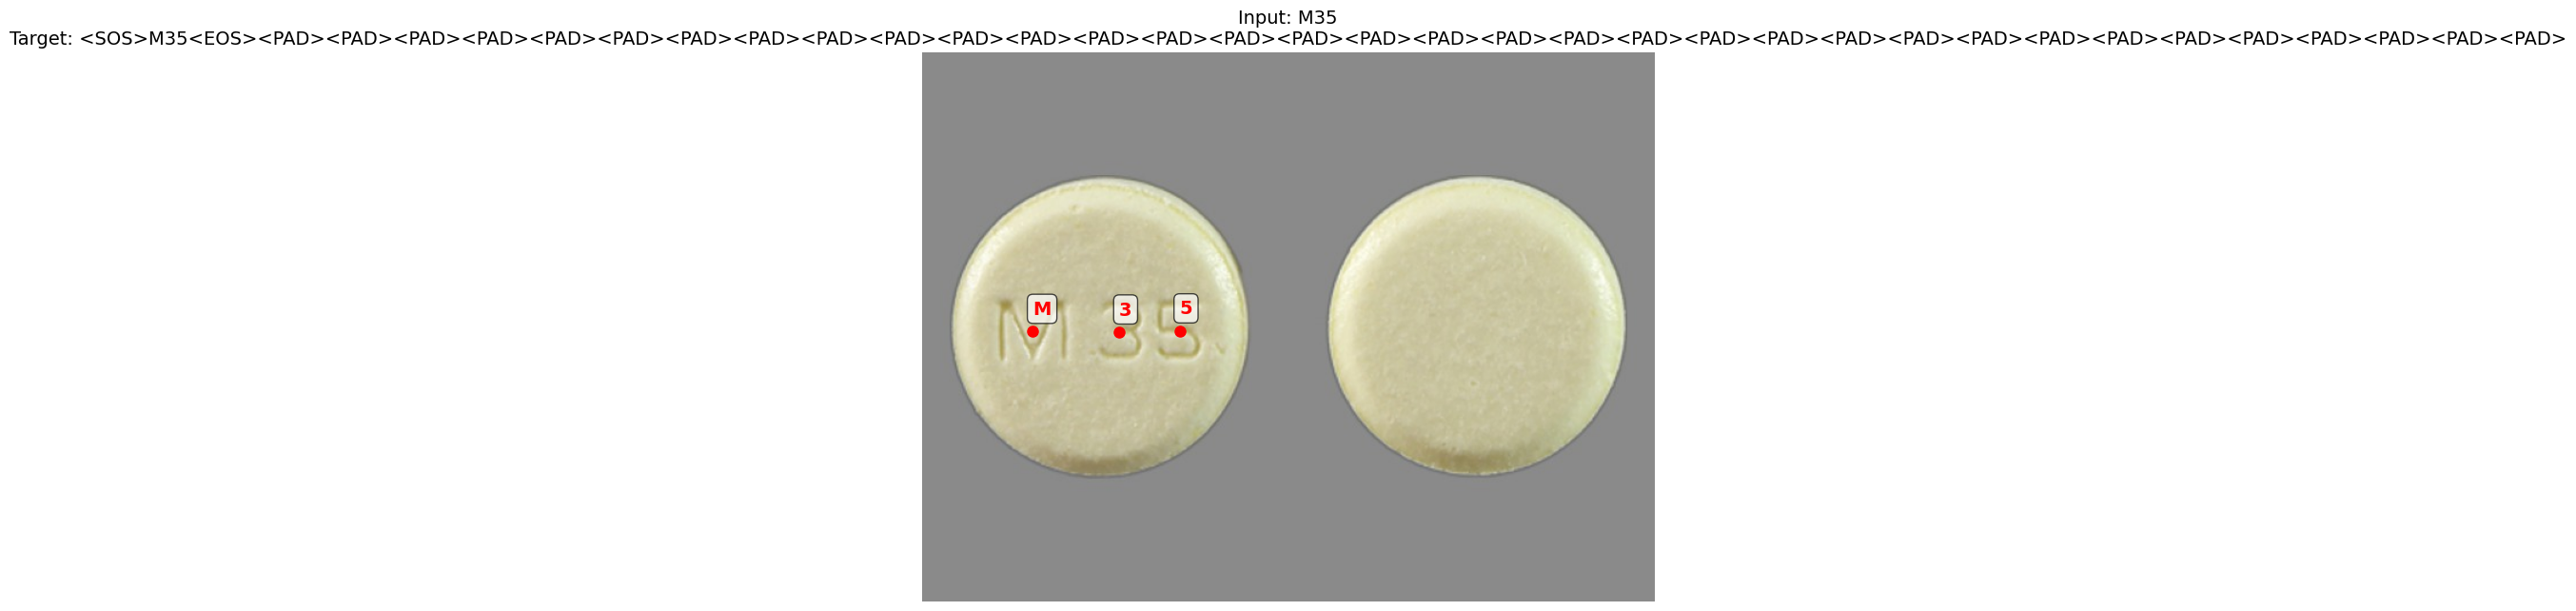


Decoding Info:
  Input vocab size (original): 34
  Target vocab size (with special tokens): 38
  Input chars from YOLO: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
  Target chars (includes SOS/EOS/PAD/_): ['<EOS>', '<PAD>', '<SOS>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

# Load the saved dataset to get the original character encoding info
dataset = torch.load('rnn_dataset.pt', weights_only=False)
INPUT_CHARS = dataset['char_encoder'].categories_[0].tolist()  # Original 33 chars used for encoding input
NUM_INPUT_CHARS = len(INPUT_CHARS)

# Random sample from training set
sample_idx = random.randint(0, len(X_train) - 1)

# Decode input (YOLO predictions) - use original 33-char vocabulary
input_chars = []
for i in range(X_train[sample_idx].shape[0]):
    char_ohe = X_train[sample_idx][i, 2:2+NUM_INPUT_CHARS]  # Use 33, not 37
    if char_ohe.sum() > 0:  # Not padding
        char_idx = char_ohe.argmax().item()
        input_chars.append(INPUT_CHARS[char_idx])

# Decode target (ground truth) - use the updated vocabulary with special tokens
target_chars = [idx_to_char[idx.item()] for idx in y_train[sample_idx] if idx.item() in idx_to_char]

# Load and display image
img_name = df_train.iloc[sample_idx]['image']
img_path = image_dir / img_name
img = Image.open(img_path)
img_width, img_height = img.size

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img)

# Draw bounding boxes from X_train (coordinates are at positions 0,1)
for i in range(X_train[sample_idx].shape[0]):
    char_ohe = X_train[sample_idx][i, 2:2+NUM_INPUT_CHARS]  # Use 33, not 37
    if char_ohe.sum() > 0:  # Not padding
        x_center = X_train[sample_idx][i, 0].item()
        y_center = X_train[sample_idx][i, 1].item()
        char_idx = char_ohe.argmax().item()
        char = INPUT_CHARS[char_idx]
        
        # Draw point at center
        ax.plot(x_center * img_width, y_center * img_height, 'ro', markersize=8)
        ax.text(x_center * img_width, y_center * img_height - 15, char,
               color='red', fontsize=14, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.axis('off')
ax.set_title(f"Input: {''.join(input_chars)}\nTarget: {''.join(target_chars)}", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nDecoding Info:")
print(f"  Input vocab size (original): {NUM_INPUT_CHARS}")
print(f"  Target vocab size (with special tokens): {len(ALL_CHARS)}")
print(f"  Input chars from YOLO: {INPUT_CHARS}")
print(f"  Target chars (includes SOS/EOS/PAD/_): {ALL_CHARS}")